## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Let's use MNIST

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid")
])

hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                  metrics=[rounded_accuracy])

history = hashing_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4998 - rounded_accuracy: 0.7265 - val_loss: 0.4848 - val_rounded_accuracy: 0.7339
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4755 - rounded_accuracy: 0.7499 - val_loss: 0.4748 - val_rounded_accuracy: 0.7624
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4307 - rounded_accuracy: 0.7956 - val_loss: 0.4218 - val_rounded_accuracy: 0.8039
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4092 - rounded_accuracy: 0.8146 - val_loss: 0.4184 - val_rounded_accuracy: 0.8067
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4018 - rounded_accuracy: 0.8207 - val_loss: 0.4158 - val_rounded_accuracy: 0.8086
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3969 - rounded_accuracy: 0.8253 - val_loss: 0.4050 - val_rounded_accuracy: 0.8120
Epoch 7/10
1719/1719 [==================

In [13]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [14]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

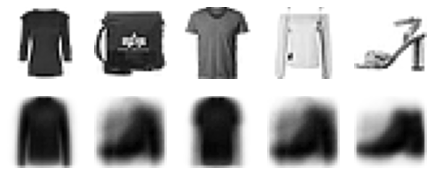

In [15]:
show_reconstructions(hashing_ae)
plt.show()

In [16]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
    
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

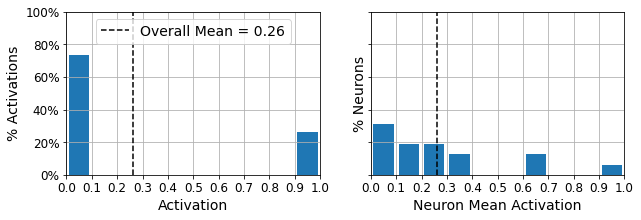

In [17]:
plot_activations_histogram(hashing_encoder)

hashing the images using trained encoder

In [18]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100000010001
0000100000000000
0000100000011001
0000100000000000
0000100001000000
...


Seperating the images according to the hash values

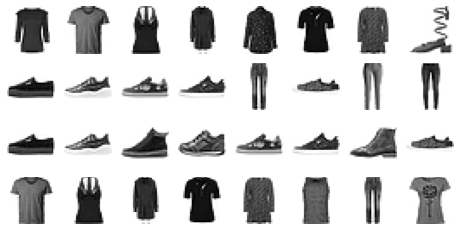

In [19]:


n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index*n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

We can see the images are seperated well into 4 groups without human intervention.
Using this method we label the unlabeled dataset.